In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [20]:
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'

In [3]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [4]:
# Reading first 15 rows of the training data
train_data.head(15)

,review_text,label
0,We had a wonderful Saturday night dinner. They...,1.0
1,Service was brilliant and the spicy and very d...,1.0
2,A nice bar and dining space in Colombo. We can...,0.0
3,We went there on 31st December 2021. They had ...,1.0
4,Nice place decorated by the natural assets. Th...,1.0
5,We dropped in for a quick drink. Dirty martini...,1.0
6,Actually its a Good place for Dinner out. The ...,1.0
7,Nice spot for dinner on the beach. We had blac...,1.0
8,It's a perfect place for a spend your friday n...,1.0
9,"Beautiful ambiance, right by the ocean. Waitst...",1.0


In [5]:
# drop empty rows from the train and the test csv files
train_data = train_data.dropna();
test_data = test_data.dropna();

In [6]:
# Size of dataset
print("Training Set:"% train_data.columns, train_data.shape) # 1288 rows for Training dataset
print("Testing Set:"% test_data.columns, test_data.shape)    # 323 rows for Testing dataset

Training Set: (1288, 2)
Testing Set: (323, 2)


c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


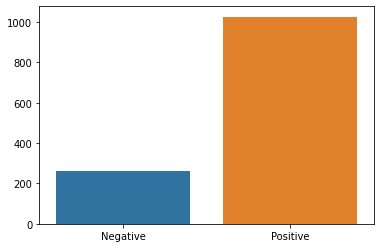

In [7]:
negative_count = len(train_data[train_data.label == 0])
positive_count = len(train_data[train_data.label == 1])

x = ["Negative", "Positive"]
y = [negative_count, positive_count]

sns.barplot(x, y)
plt.show()

In [8]:
def  clean_text(df, text_field): #
    # This function removes all unnecessary characters from the text
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

train_clean = clean_text(train_data, "review_text")
test_clean = clean_text(test_data, "review_text")

In [9]:
train_clean.head(15)

,review_text,label
0,we had a wonderful saturday night dinner they ...,1.0
1,service was brilliant and the spicy and very d...,1.0
2,a nice bar and dining space in colombo we can ...,0.0
3,we went there on 31st december 2021 they had a...,1.0
4,nice place decorated by the natural assets the...,1.0
5,we dropped in for a quick drink dirty martini ...,1.0
6,actually its a good place for dinner out the d...,1.0
7,nice spot for dinner on the beach we had black...,1.0
8,its a perfect place for a spend your friday ni...,1.0
9,beautiful ambiance right by the ocean waitstaf...,1.0


In [10]:
# Getting count of Negative and Positive label from train dataset
print("Negative count from the train dataset: ", len(train_clean[train_clean.label == 0]))
print("Positive count from the train dataset: ", len(train_clean[train_clean.label == 1]))

# The output is clearly imbalanced

Negative count from the train dataset:  261
Positive count from the train dataset:  1027


In [11]:
train_negative = train_clean[train_clean.label == 0]
train_positive = train_clean[train_clean.label == 1]

train_negative_upsampled = resample(train_negative, 
                                replace=True,    
                                n_samples=len(train_positive),   
                                random_state=123)

train_upsampled = pd.concat([train_negative_upsampled, train_positive])
train_upsampled['label'].value_counts()

1.0    1027
0.0    1027
Name: label, dtype: int64

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


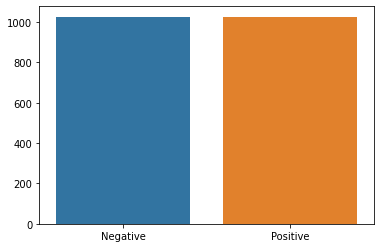

In [12]:
x = ["Negative", "Positive"]
y = [len(train_upsampled[train_upsampled.label == 0 ]), len(train_upsampled[train_upsampled.label == 1 ])]

sns.barplot(x, y)
plt.show()

In [26]:
# Building the Stacked Modal
sdg = SGDClassifier()
bnb = BernoulliNB()
svc = SVC()
rfc = RandomForestClassifier()

estimator_list = [('sdg', sdg), ('bnb', bnb), ('svc', svc), ('rfc', rfc)]

stacked = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

In [27]:
pipeline_sgd = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', sdg),])

pipeline_bnb = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', bnb),])

pipeline_svc = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', svc),])

pipeline_rfc = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', rfc),])

pipeline_stacked = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf',  TfidfTransformer()), 
                         ('nb', stacked),])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train_upsampled['review_text'],
                                                    train_upsampled['label'],
                                                    random_state = 0)
models = []

model_sgd = pipeline_sgd.fit(X_train, y_train)
model_bnb = pipeline_bnb.fit(X_train, y_train)
model_svc = pipeline_svc.fit(X_train, y_train)
model_rfc = pipeline_rfc.fit(X_train, y_train)
model_stacked = pipeline_stacked.fit(X_train, y_train)

models.append({"name": "model_sgd", "model": model_sgd})
models.append({"name": "model_bnb", "model": model_bnb})
models.append({"name": "model_svc", "model": model_svc})
models.append({"name": "model_rfc", "model": model_rfc})
models.append({"name": "model_stacked", "model": model_stacked})

In [29]:
for index in range (len(models)):
    print("Model name:", models[index]['name'])
    y_predict = models[index]['model'].predict(X_test)
    f1_score_result = f1_score(y_test, y_predict)
    accuracy_score_result = accuracy_score(y_test, y_predict)
    precision_score_result = precision_score(y_test, y_predict)

    print("F1 score %s" % round(f1_score_result*100, 2), "%")
    print("Accuracy score %s" % round(accuracy_score_result*100, 2), "%")
    print("Precision score %s" % round(precision_score_result*100, 2), "%")
    print("-----------------------")

Model name: model_sgd
F1 score 91.26 %
Accuracy score 92.02 %
Precision score 96.83 %
-----------------------
Model name: model_bnb
F1 score 77.18 %
Accuracy score 72.96 %
Precision score 65.1 %
-----------------------
Model name: model_svc
F1 score 95.95 %
Accuracy score 96.11 %
Precision score 96.34 %
-----------------------
Model name: model_rfc
F1 score 95.65 %
Accuracy score 95.91 %
Precision score 98.3 %
-----------------------
Model name: model_stacked
F1 score 96.15 %
Accuracy score 96.3 %
Precision score 96.73 %
-----------------------


In [25]:
pickle.dump(models[2]['model'], open("model", 'wb'))

In [26]:
loaded_model = pickle.load(open("model", 'rb'))

In [27]:
print(loaded_model)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('nb', SVC())])


In [28]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    return text

In [39]:
test_data = pd.read_csv(test_path)

for i in range (test_data.size-1):
    review = test_data.iloc[i]['review_text']
    review = clean_text(review)

    output = ["Negative", "Positive"]
    result = loaded_model.predict(pd.Series(review))[0]
    if(result == 0):
        print(review, "<==>", output[int(result)])
        print()

food is not up to the mark <==> Negative

ok place <==> Negative

quality has gone down <==> Negative

bad service from their manager <==> Negative

very bad customer service <==> Negative

tastiest food ever <==> Negative

price is reasonable <==> Negative

poor customer service <==> Negative

reasonable price <==> Negative

poor service <==> Negative

foods not tasty <==> Negative

food is not good <==> Negative

some foods overpriced <==> Negative

expensive and poor services <==> Negative

poor customer service <==> Negative

food was tasteless <==> Negative

the worst crew <==> Negative

not happy with the service <==> Negative

happy <==> Negative

poor customer service <==> Negative

nice food <==> Negative

very poor <==> Negative

poor customer service <==> Negative

bad safety <==> Negative

service is poor <==> Negative

average food <==> Negative

too expensive <==> Negative

worst today <==> Negative

you better bring some mosquito coils to this place we informed to the st

AttributeError: ignored